In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../')
from pyhip import HIP

In [3]:
vevo_path = "G:/MLCV dataset/quality_videos/vevo.json"

In [4]:
with open(vevo_path, "r") as f:
    vevo_json = f.readlines()

In [5]:
# FMVyXDU9bN4
record = json.loads(vevo_json[0])
print(record.keys())
cols = record['insights']
cols.keys()

dict_keys(['topicDetails', 'statistics', 'contentDetails', 'snippet', 'id', 'insights'])


dict_keys(['startDate', 'dailyShare', 'totalShare', 'avgWatch', 'dailySubscriber', 'totalSubscriber', 'days', 'totalView', 'dailyView', 'dailyWatch'])

In [6]:
days = []
for line in vevo_json:
    vevo_record = json.loads(line)
    days.append(len(vevo_record['insights']['days'].split(",")))

In [7]:
pd_days = pd.DataFrame(days)
pd_days.describe()

,0
count,67649.000000
mean,835.434404
std,414.928623
min,3.000000
25%,489.000000
50%,819.000000
75%,1187.000000
max,1633.000000


In [8]:
vevo_videos = {}
for line in vevo_json:
    vevo_record = json.loads(line)
    try:
        vevo_videos[vevo_record['id']] = ([int(x) for x in vevo_record['insights']['dailyShare'].split(",")],\
                                      [int(x) for x in vevo_record['insights']['dailyView'].split(",")],\
                                      [float(x) for x in vevo_record['insights']['dailyWatch'].split(",")])
    except:
        continue
print("dataset size:", len(vevo_videos))

dataset size: 67556


## Evaluate HIP on Vevo

In [ ]:
test_vid = 'FMVyXDU9bN4'
daily_share, daily_view, daily_watch = vevo_videos[test_vid]
print("Video {} has record of {} days".format(test_vid, len(daily_share)))
num_train = 90
num_test = 30
num_initialization = 25

In [ ]:
hip_model = HIP()
hip_model.initial(daily_share, daily_view, num_train, num_test, num_initialization)
hip_model.fit_with_bfgs()
hip_model.print_parameters()
hip_model.plot_func('YouTubeID={0}'.format(test_vid))

In [ ]:
num_train = 600
num_test = 200
num_initialization = 25

hip_model = HIP()
hip_model.initial(daily_share, daily_view, num_train, num_test, num_initialization)
hip_model.fit_with_bfgs()
hip_model.print_parameters()
hip_model.plot_func('YouTubeID={0}'.format(test_vid))

### HIP performance variation wrt long term

In [9]:
start_time = time.time()
size = 10
count = 0

num_train = 90
num_test = 540
num_initialization = 25

preds_y = []
gts_y = []
test_vids = []
for test_vid in list(vevo_videos.keys()):
    daily_share, daily_view, daily_watch = vevo_videos[test_vid]
    if len(daily_view) <= (num_train + num_test): continue
    test_vids.append(test_vid)
    hip_model = HIP()
    hip_model.initial(daily_share, daily_view, num_train, num_test, num_initialization)
    hip_model.fit_with_bfgs()
    
    y_predict = hip_model.predict(hip_model.get_parameters_abbr(), hip_model.x)
    preds_y.append(y_predict)
    gts_y.append(np.array(hip_model.y))
    count += 1
    
    if count >= size: break
print('>>> Total time: {0}'.format(str(timedelta(seconds=time.time() - start_time)))[:-3])

--- Finish initialization set 5...
--- Finish initialization set 10...
--- Finish initialization set 15...
--- Finish initialization set 20...
--- Finish initialization set 25...
--- Model fitting RMSE: 165.96
--- Model forecast RMSE: 52.18
--- Finish initialization set 5...
--- Finish initialization set 10...
--- Finish initialization set 15...
--- Finish initialization set 20...
--- Finish initialization set 25...
--- Model fitting RMSE: 591.12
--- Model forecast RMSE: 105.97
--- Finish initialization set 5...
--- Finish initialization set 10...
--- Finish initialization set 15...
--- Finish initialization set 20...
--- Finish initialization set 25...
--- Model fitting RMSE: 231.99
--- Model forecast RMSE: 135.39
--- Finish initialization set 5...
--- Finish initialization set 10...
--- Finish initialization set 15...
--- Finish initialization set 20...
--- Finish initialization set 25...
--- Model fitting RMSE: 2082.38
--- Model forecast RMSE: 4477.89
--- Finish initialization set 5

In [40]:
preds_y_eval = []
gts_y_eval = []
eval_days = np.arange(30, num_test, 10)
for i in range(len(preds_y)):
    pred_y_accu = [np.sum(preds_y[i][:num_train+eval_day]) for eval_day in eval_days]
    gt_y_accu = [np.sum(gts_y[i][:num_train+eval_day]) for eval_day in eval_days]
    preds_y_eval.append(pred_y_accu)
    gts_y_eval.append(gt_y_accu)

In [41]:
df_preds_eval = pd.DataFrame(preds_y_eval, columns =eval_days)#, index = test_vids)
df_gts_eval = pd.DataFrame(gts_y_eval, columns =eval_days)#, index = test_vids)
pop_scales = np.linspace(0, 1, len(df_preds_eval[eval_days[0]]))

df_perc_errors = []
for eval_day in eval_days:
    perc_error = []
    pred_sort = df_preds_eval.sort_values(by=[eval_day], inplace=False)
    gt_sort = df_gts_eval.sort_values(by=[eval_day], inplace=False)
    pred_sort[eval_day] = pop_scales
    gt_sort[eval_day] = pop_scales
    
    for ind in pred_sort.index:
        perc_error.append(np.abs(pred_sort.loc[ind, eval_day]-gt_sort.loc[ind, eval_day]))
    df_perc_error = pd.DataFrame(perc_error, columns =[eval_day], index = pred_sort.index)
    df_perc_errors.append(df_perc_error)

mean_perc_errors = []
for df in df_perc_errors:
    mean_perc_errors.append(np.sum(df.to_numpy())/size)
df_mean_perc_errors = pd.DataFrame([mean_perc_errors], columns =eval_days)
display(df_mean_perc_errors)

,30,40,50,60,70,80,90,100,110,120,...,440,450,460,470,480,490,500,510,520,530
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,...,0.044444,0.044444,0.044444,0.044444,0.044444,0.044444,0.044444,0.044444,0.044444,0.044444


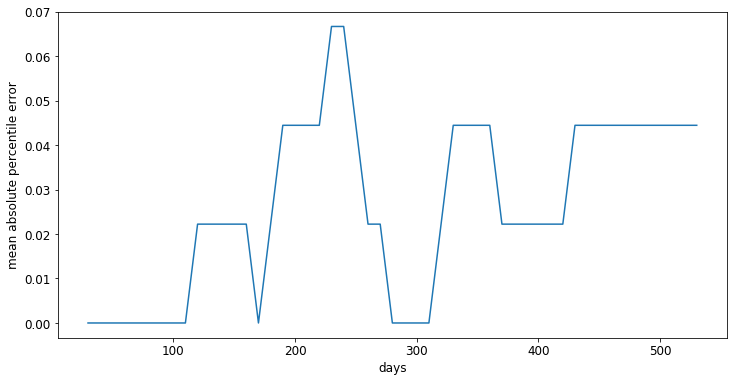

In [43]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df_mean_perc_errors.loc[0,:])
ax1.set_xlabel("days")
ax1.set_ylabel("mean absolute percentile error")
pass